# Подготовка данных

In [18]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [2]:
%matplotlib inline
pd.options.display.float_format ='{:,.3f}'.format
%config InlineBackend.figure_format = 'svg' 

In [3]:
train_data = pd.read_csv('data/train.csv')
train_data

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,"482,087.000",NaN,0.000,11.000,26.300,"685,960.000",1.000,NaN,1.000,debt consolidation,Short Term,"99,999,999.000","47,386.000","7,914.000",749.000,0
1,Own Home,"1,025,487.000",10+ years,0.000,15.000,15.300,"1,181,730.000",0.000,NaN,0.000,debt consolidation,Long Term,"264,968.000","394,972.000","18,373.000",737.000,1
2,Home Mortgage,"751,412.000",8 years,0.000,11.000,35.000,"1,182,434.000",0.000,NaN,0.000,debt consolidation,Short Term,"99,999,999.000","308,389.000","13,651.000",742.000,0
3,Own Home,"805,068.000",6 years,0.000,8.000,22.500,"147,400.000",1.000,NaN,1.000,debt consolidation,Short Term,"121,396.000","95,855.000","11,338.000",694.000,0
4,Rent,"776,264.000",8 years,0.000,13.000,13.600,"385,836.000",1.000,NaN,0.000,debt consolidation,Short Term,"125,840.000","93,309.000","7,180.000",719.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,"402,192.000",< 1 year,0.000,3.000,8.500,"107,866.000",0.000,NaN,0.000,other,Short Term,"129,360.000","73,492.000","1,900.000",697.000,0
7496,Home Mortgage,"1,533,984.000",1 year,0.000,10.000,26.500,"686,312.000",0.000,43.000,0.000,debt consolidation,Long Term,"444,048.000","456,399.000","12,783.000","7,410.000",1
7497,Rent,"1,878,910.000",6 years,0.000,12.000,32.100,"1,778,920.000",0.000,NaN,0.000,buy a car,Short Term,"99,999,999.000","477,812.000","12,479.000",748.000,0
7498,Home Mortgage,NaN,NaN,0.000,21.000,26.500,"1,141,250.000",0.000,NaN,0.000,debt consolidation,Short Term,"615,274.000","476,064.000","37,118.000",NaN,0


Функции для подготовки данных.

In [4]:
def prepare_data_v1(data):
    prepared_data = pd.get_dummies(data, prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)
    transform_dict = {'< 1 year':0.5, '10+ years':10, '2 years':2, '3 years':3, '5 years':5, '1 year':1, '4 years':4, '6 years':6, '7 years':7, '8 years':8, '9 years':9}
    prepared_data['Years in current job'] = data['Years in current job'].replace(transform_dict, None)
    prepared_data['Term'] = data['Term'].replace({'Long Term':1, 'Short Term':0}, None)
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].replace(99999999, np.nan)
    prepared_data['Credit Score'] = data['Credit Score'].apply(lambda x: x/10 if (x > 1000) else x)
    return prepared_data

def prepare_data_v2(data):
    prepared_data = pd.get_dummies(data, prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)  
    transform_dict = {'< 1 year':0, '10+ years':1, '2 years':0, '3 years':0, '5 years':0, '1 year':0, '4 years':0, '6 years':0, '7 years':0, '8 years':0, '9 years':0}
    prepared_data['Years in current job'] = data['Years in current job'].replace(transform_dict, None)
    prepared_data['Term'] = data['Term'].replace({'Long Term':1, 'Short Term':0}, None)
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].replace(99999999, np.nan)
    prepared_data['Credit Score'] = data['Credit Score'].apply(lambda x: x/10 if (x > 1000) else x)
    prepared_data['Tax Liens'] = data['Tax Liens'].apply(lambda x: 0 if (x == 0) else 1)
    prepared_data['Number of Credit Problems'] = data['Number of Credit Problems'].apply(lambda x: 0 if (x == 0) else 1)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].apply(lambda x: 0 if x == 0 else 1)
    threshold = 10000000
    prepared_data['Maximum Open Credit'] = data['Maximum Open Credit'].apply(lambda x: threshold if (x > threshold) else x)
    return prepared_data

def fill_na_v1(data):
    prepared_data = data
    prepared_data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].mean())
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].fillna(data['Current Loan Amount'].mean())
    prepared_data['Credit Score'] = data['Credit Score'].fillna(data['Credit Score'].mean())    
    prepared_data['Years in current job'] = data['Years in current job'].fillna(0)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].fillna(data['Number of Credit Problems'].apply(lambda x: 0 if (x == 0) else 1)) 
    prepared_data['Months since last delinquent'] = data['Months since last delinquent'].fillna(data['Months since last delinquent'].mean())
    return prepared_data

def fill_na_v2(data):
    prepared_data = data
    prepared_data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].mean())
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].fillna(data['Current Loan Amount'].mean())
    prepared_data['Credit Score'] = data['Credit Score'].fillna(data['Credit Score'].mean())    
    prepared_data['Years in current job'] = data['Years in current job'].fillna(0)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].fillna(data['Number of Credit Problems'].apply(lambda x: 0 if (x == 0) else 1)) 
    prepared_data = prepared_data.drop('Months since last delinquent', axis=1)
    return prepared_data

def prepare_data_v3(data):
    prepared_data = pd.get_dummies(data, prefix=['ho', 'p'], columns = ['Home Ownership', 'Purpose'], drop_first=False)
    transform_dict = {'< 1 year':0.1, '10+ years':10, '2 years':2, '3 years':3, '5 years':5, '1 year':1, '4 years':4, '6 years':6, '7 years':7, '8 years':8, '9 years':9}
    prepared_data['Years in current job'] = data['Years in current job'].replace(transform_dict, None)
    prepared_data['Term'] = data['Term'].replace({'Long Term':1, 'Short Term':0}, None)
    prepared_data['Credit Score'] = data['Credit Score'].apply(lambda x: x/10 if (x > 1000) else x)
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].replace(99999999, np.nan)

    return prepared_data

def fill_na_v3(data):
    big_value = 100000000000000
    prepared_data = data
    prepared_data['Annual Income'] = data['Annual Income'].fillna(big_value)
    prepared_data['Current Loan Amount'] = data['Current Loan Amount'].fillna(big_value)
    prepared_data['Credit Score'] = data['Credit Score'].fillna(big_value)
    
    prepared_data['Years in current job'] = data['Years in current job'].fillna(big_value)
    prepared_data['Bankruptcies'] = data['Bankruptcies'].fillna(big_value)  
    prepared_data = prepared_data.drop('Months since last delinquent', axis=1)
    return prepared_data

def preprocessing_data_fit(data):
    fits = {}
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
    fits['Annual Income'] = pt.fit(np.array(data['Annual Income']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Number of Open Accounts'] = pt.fit(np.array(data['Number of Open Accounts']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Years of Credit History'] = pt.fit(np.array(data['Years of Credit History']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Current Loan Amount'] = pt.fit(np.array(data['Current Loan Amount']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)  
    fits['Current Credit Balance'] = pt.fit(np.array(data['Current Credit Balance']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Monthly Debt'] = pt.fit(np.array(data['Monthly Debt']).reshape(-1, 1))
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    fits['Credit Score'] = pt.fit(np.array(data['Credit Score']).reshape(-1, 1))
    #pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
    #fits['Months since last delinquent'] = pt.fit(np.array(data['Months since last delinquent']).reshape(-1, 1))
    
    ss = preprocessing.StandardScaler()
    fits['Years in current job'] = ss.fit(np.array(data['Years in current job']).reshape(-1, 1))
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    fits['Maximum Open Credit'] = qt.fit(np.array(data['Maximum Open Credit']).reshape(-1, 1))

    return fits

def preprocessing_data_transform(data, fits):
    prepared_data = data   
    for key in fits:
        print(key)
        prepared_data[key] = pd.DataFrame(fits[key].transform(np.array(data[key]).reshape(-1, 1)))
    return prepared_data

Пайплайны для подготовки данных.

In [5]:
def pipeline_v1(data):
    data_prepared = prepare_data_v1(data)
    data_prepared = fill_na_v1(data_prepared)
    #fits = preprocessing_data_fit(data_prepared)
    #data_prepared = preprocessing_data_transform(data_prepared, fits)
    return data_prepared

def pipeline_v2(data):
    data_prepared = prepare_data_v2(data)
    data_prepared = fill_na_v2(data_prepared)
    fits = preprocessing_data_fit(data_prepared)
    data_prepared = preprocessing_data_transform(data_prepared, fits)
    return data_prepared

def pipeline_v3(data):
    data_prepared = prepare_data_v3(data)
    data_prepared = fill_na_v3(data_prepared)
    return data_prepared

## Обучение

Выберем необходимый пайплайн.

In [50]:
train_data_prepared = pipeline_v2(train_data)
train_data_prepared.iloc[:,:14].describe()

Annual Income
Number of Open Accounts
Years of Credit History
Current Loan Amount
Current Credit Balance
Monthly Debt
Credit Score
Years in current job
Maximum Open Credit


,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,"7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000","7,500.000"
mean,0.000,-0.000,0.018,-0.000,0.000,-0.016,0.137,0.112,0.259,0.000,0.000,0.000,-0.000,0.282
std,1.000,1.000,0.132,1.000,1.000,1.102,0.344,0.315,0.438,1.000,1.000,1.000,1.000,0.450
min,-4.214,-0.672,0.000,-3.015,-3.489,-5.199,0.000,0.000,0.000,-3.036,-3.370,-3.781,-2.372,0.000
25%,-0.581,-0.672,0.000,-0.569,-0.634,-0.674,0.000,0.000,0.000,-0.689,-0.593,-0.636,-0.508,0.000
50%,0.237,-0.672,0.000,-0.078,-0.032,-0.000,0.000,0.000,0.000,0.168,-0.028,0.000,-0.269,0.000
75%,0.436,1.489,0.000,0.713,0.636,0.674,0.000,0.000,1.000,0.634,0.572,0.630,0.816,1.000
max,4.593,1.489,1.000,3.758,3.402,5.199,1.000,1.000,1.000,2.191,6.055,4.926,1.901,1.000


Разделим данные на тренировочные и тестовые.

In [81]:
target = 'Credit Default'
X = np.array(train_data_prepared.iloc[:, train_data_prepared.columns != target])
y = np.array(train_data_prepared[target].astype(int))
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

Сбалансируем тренировочные данные оверсемплингом и разделим на тренировочные и валидационные.

In [82]:
#from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
#ros = RandomOverSampler(random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=4, stratify=y_train_all)
X_resample, y_resample = ros.fit_resample(X_train, y_train)


In [47]:
# Загружаем алгоритмы модели
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC(C=1, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                      probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                      max_iter=-1, decision_function_shape='ovr', break_ties=False)))
models.append(('RF', xgb.XGBRFClassifier(n_estimators=40, max_depth=8, learning_rate=0.3, verbosity=1, objective='binary:logistic',
                     gamma=19, min_child_weight=1, max_delta_step=0, subsample=0.8, colsample_bynode=0.9, colsample_bylevel=0.9,
                     reg_lambda=0.2, reg_alpha=0, eval_metric=['auc','logloss'], use_label_encoder=False)))
models.append(('XGB', xgb.XGBClassifier(max_depth=8, learning_rate=0.3, verbosity=1, objective='binary:logistic',
                     gamma=20, min_child_weight=1, max_delta_step=0, subsample=0.8, colsample_bynode=0.9, colsample_bylevel=0.9,
                     reg_lambda=0, reg_alpha=0, eval_metric=['auc','logloss'], use_label_encoder=False)))

# оцениваем модель на каждой итерации
results = []
names = []

for name, model in models:
	kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.016347 (0.004333)
KNN: 0.263506 (0.031643)
CART: 0.379083 (0.019831)
SVM: 0.000000 (0.000000)
RF: 0.008023 (0.016046)
XGB: 0.143182 (0.050324)


In [85]:
history = {'param':[], 'auc':[], 'f1_score':[], 'epohs':[]}

for i in range (1, 15):
    #param_value=0.001*(2**i)
    param_value=i*1
    print(param_value)
    rf = xgb.XGBRFClassifier(n_estimators=35, max_depth=8, learning_rate=0.3, verbosity=1, objective='binary:logistic',
                             gamma=19, min_child_weight=0, max_delta_step=3, subsample=0.8, colsample_bynode=0.9, colsample_bylevel=0.9,
                             reg_lambda=0.2, reg_alpha=0)
    rf.fit(X_resample, y_resample, eval_metric=['auc','logloss'])
    y_pred = rf.predict(X_val)

    print(f'f1_score: {f1_score(y_val, y_pred, average="binary")}')
    print(f'auc: {roc_auc_score(y_val, y_pred)}')
    print(confusion_matrix(y_val, y_pred))
    print(f'acc: {accuracy_score(y_val, y_pred)}')

    history['param'].append(param_value)
    history['f1_score'].append(f1_score(y_val, y_pred, average='binary'))
    history['auc'].append(roc_auc_score(y_val, y_pred))

1
f1_score: 0.449748743718593
auc: 0.6029599527725531
[[583 279]
 [159 179]]
acc: 0.635
2


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.4429530201342282
auc: 0.6037116105383105
[[620 242]
 [173 165]]
acc: 0.6541666666666667
3


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5052631578947369
auc: 0.639252323617842
[[490 372]
 [ 98 240]]
acc: 0.6083333333333333
4


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5292368681863232
auc: 0.6606316671014154
[[458 404]
 [ 71 267]]
acc: 0.6041666666666666
5


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5253863134657837
auc: 0.6606556926921018
[[532 330]
 [100 238]]
acc: 0.6416666666666667
6


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5276872964169381
auc: 0.6622516783591208
[[522 340]
 [ 95 243]]
acc: 0.6375
7


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5334750265674814
auc: 0.6671254410412005
[[510 352]
 [ 87 251]]
acc: 0.6341666666666667
8


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5276595744680851
auc: 0.6615274784112907
[[508 354]
 [ 90 248]]
acc: 0.63
9


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5304812834224598
auc: 0.6644277104298522
[[513 349]
 [ 90 248]]
acc: 0.6341666666666667
10


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5268817204301076
auc: 0.6611499334147916
[[515 347]
 [ 93 245]]
acc: 0.6333333333333333
11


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5221143473570659
auc: 0.6567120635923063
[[515 347]
 [ 96 242]]
acc: 0.6308333333333334
12


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5199568500539374
auc: 0.6546527272477656
[[514 348]
 [ 97 241]]
acc: 0.6291666666666667
13


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.5193965517241379
auc: 0.6540726808440535
[[513 349]
 [ 97 241]]
acc: 0.6283333333333333
14


D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.521081081081081
auc: 0.6558128200551901
[[516 346]
 [ 97 241]]
acc: 0.6308333333333334


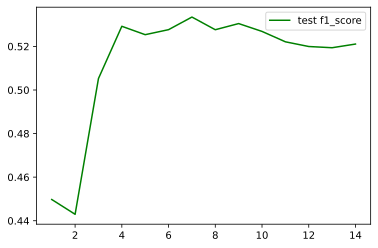

In [86]:
start = 0
plt.clf()
epochs = history['param'][start:]#
plt.plot(epochs, history['f1_score'][start:], 'g', label='test f1_score')
plt.legend()
plt.show()

In [89]:
rf = xgb.XGBRFClassifier(n_estimators=35, max_depth=8, learning_rate=0.3, verbosity=1, objective='binary:logistic',
                             gamma=19, min_child_weight=0, max_delta_step=3, subsample=0.8, colsample_bynode=0.9, colsample_bylevel=0.9,
                             reg_lambda=0.2, reg_alpha=0)
rf.fit(X_resample, y_resample, eval_metric=['auc','logloss'])
ypred = rf.predict(X_test)
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in ypred]
print(f'f1_score: {f1_score(y_test, predictions, average="binary")}')
print(f'auc: {roc_auc_score(y_test, predictions)}')
print(confusion_matrix(y_test, predictions))
print(f'acc: {accuracy_score(y_test, predictions)}')

D:\git\project2\ml\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


f1_score: 0.47918436703483425
auc: 0.6142061281337048
[[605 472]
 [141 282]]
acc: 0.5913333333333334


In [100]:
d_train = xgb.DMatrix(X_resample, label=y_resample)
d_val = xgb.DMatrix(X_val, label=y_val)

history = {'param':[], 'auc':[], 'logloss':[]}
evallist = [(d_train, 'train'), (d_val, 'eval')]
hist={}
for i in range (15):
    #param_value=0.001*(2**i)
    param_value=i*5
    print(param_value)
    
    param = {'max_depth': param_value, 
         'eta': 0.3, 
         'objective': 'binary:logistic', 
         'subsample': 0.8, 
         'gamma': 20, 
         'min_child_weight':1,
         'reg_lambda': 0, 
         'reg_alpha':0, 
         'max_delta_step':0,
         'colsample_bynode':0.9,#0.5
         'colsample_bytree':1,
         'colsample_bylevel':0.9#0.5
            } 
    param['eval_metric'] = ['auc', 'logloss']

    res = xgb.cv(param, d_train, 1000, nfold=5, metrics=param['eval_metric'], as_pandas=False, seed=0, stratified=True, callbacks=[xgb.callback.EarlyStopping(10)])#xgb.callback.EvaluationMonitor(show_stdv=False), 


    print(f'param: {param_value}')
    print(f'auc: {res["train-auc-mean"][-1]}')
    print(f'logloss: {res["train-logloss-mean"][-1]}')

    
    history['param'].append(param_value)
    history['auc'].append(res['train-auc-mean'][-1])
    history['logloss'].append(res['train-logloss-mean'][-1])


0
param: 0
auc: 0.5
logloss: 0.6931476
5
param: 5
auc: 0.7855626
logloss: 0.5607906
10
param: 10
auc: 0.8174044
logloss: 0.5368552
15
param: 15
auc: 0.8734052
logloss: 0.47890240000000006
20
param: 20
auc: 0.867798
logloss: 0.485548
25


KeyboardInterrupt: 

In [ ]:
start = 0
plt.clf()
epochs = history['param'][start:]#
plt.plot(epochs, history['auc'][start:], 'g', label='test f1_score')
plt.legend()
plt.show()

In [104]:
param = {'max_depth': 8, 
         'eta': 0.3, 
         'objective': 'binary:logistic', 
         'subsample': 0.8, 
         'gamma': 20, 
         'min_child_weight':1,
         'reg_lambda': 0, 
         'reg_alpha':0, 
         'max_delta_step':0,
         'colsample_bynode':0.9,#0.5
         'colsample_bytree':1,
         'colsample_bylevel':0.9#0.5} 
param['eval_metric'] = ['auc', 'logloss']
    
d_test = xgb.DMatrix(X_test, label=y_test)
bst = xgb.train(param, d_train, 2000, evallist, verbose_eval=10, evals_result=hist, early_stopping_rounds=10)
#bst.save_model('0001.model')

y_pred = bst.predict(d_test, iteration_range=(0, bst.best_iteration))
threshold = 0.5
y_pred = [1 if val > threshold else 0 for val in y_pred]
print(f'f1_score: {f1_score(y_test, y_pred, average="binary")}')
print(f'auc: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(f'acc: {accuracy_score(y_test, y_pred)}')

[0]	train-auc:0.74023	train-logloss:0.64377	eval-auc:0.68158	eval-logloss:0.65780
[10]	train-auc:0.80674	train-logloss:0.55718	eval-auc:0.72586	eval-logloss:0.60518
[20]	train-auc:0.84230	train-logloss:0.51920	eval-auc:0.72664	eval-logloss:0.59458
[30]	train-auc:0.85672	train-logloss:0.50336	eval-auc:0.73106	eval-logloss:0.58881
[40]	train-auc:0.85672	train-logloss:0.50336	eval-auc:0.73106	eval-logloss:0.58889
[41]	train-auc:0.86393	train-logloss:0.49630	eval-auc:0.72135	eval-logloss:0.59144
f1_score: 0.4527956003666361
auc: 0.5965118499641109
[[656 421]
 [176 247]]
acc: 0.602


In [114]:
from imblearn.ensemble import RUSBoostClassifier

history = {'param':[], 'auc':[], 'f1_score':[], 'epohs':[]}

for i in range (1, 15):
    #param_value=0.001*(2**i)
    param_value=i*10
    print(param_value)
    model = RUSBoostClassifier(n_estimators=30, algorithm='SAMME.R', random_state=1)
    model.fit(X_resample, y_resample)  
    y_pred = model.predict(X_val)

    print(f'f1_score: {f1_score(y_val, y_pred)}')
    print(f'auc: {roc_auc_score(y_val, y_pred)}')
    print(confusion_matrix(y_val, y_pred))
    print(f'acc: {accuracy_score(y_val, y_pred)}')
    history['param'].append(param_value)
    history['f1_score'].append(f1_score(y_val, y_pred, average='binary'))
    history['auc'].append(roc_auc_score(y_val, y_pred))

10
f1_score: 0.5248677248677249
auc: 0.6586272463927292
[[503 359]
 [ 90 248]]
acc: 0.6258333333333334
20
f1_score: 0.5211581291759466
auc: 0.6570587185436373
[[536 326]
 [104 234]]
acc: 0.6416666666666667
30
f1_score: 0.5334773218142548
auc: 0.6675887917187221
[[521 341]
 [ 91 247]]
acc: 0.64
40
f1_score: 0.5288888888888889
auc: 0.6641359711143756
[[538 324]
 [100 238]]
acc: 0.6466666666666666
50
f1_score: 0.5224839400428266
auc: 0.6567704114554017
[[510 352]
 [ 94 244]]
acc: 0.6283333333333333
60
f1_score: 0.5169769989047098
auc: 0.6524766951770343
[[523 339]
 [102 236]]
acc: 0.6325
70
f1_score: 0.5245901639344263
auc: 0.6595539477477725
[[525 337]
 [ 98 240]]
acc: 0.6375
80
f1_score: 0.5167785234899329
auc: 0.6532008951248645
[[537 325]
 [107 231]]
acc: 0.64
90
f1_score: 0.5084364454443194
auc: 0.6458044454207225
[[537 325]
 [112 226]]
acc: 0.6358333333333334
100
f1_score: 0.516629711751663
auc: 0.6526791965842476
[[531 331]
 [105 233]]
acc: 0.6366666666666667
110
f1_score: 0.513392

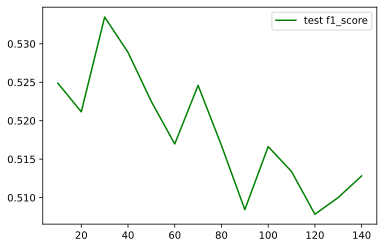

In [115]:
start = 0
plt.clf()
epochs = history['param'][start:]#
plt.plot(epochs, history['f1_score'][start:], 'g', label='test f1_score')
plt.legend()
plt.show()

In [116]:
model = RUSBoostClassifier(n_estimators=30, algorithm='SAMME.R', random_state=1)
model.fit(X_resample, y_resample)  
y_pred = model.predict(X_test)

print(f'f1_score: {f1_score(y_test, y_pred)}')
print(f'auc: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(f'acc: {accuracy_score(y_test, y_pred)}')

f1_score: 0.48090277777777773
auc: 0.617581013716852
[[625 452]
 [146 277]]
acc: 0.6013333333333334


In [117]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(n_estimators=35, criterion='gini', verbose=1, random_state=1)
model.fit(X_resample, y_resample)
y_pred = model.predict(X_test)

print(f'f1_score: {f1_score(y_test, y_pred, average="binary")}')
print(f'auc: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(f'acc: {accuracy_score(y_test, y_pred)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


f1_score: 0.35537190082644626
auc: 0.5717023252138526
[[903 174]
 [294 129]]
acc: 0.688


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished


In [118]:
param = {'max_depth': 6, 
         'eta': 0.3, 
         'objective': 'binary:logistic', 
         'subsample': 0.8, 
         'gamma': 0, 
         'min_child_weight':2,
         'reg_lambda': 2, 
         'reg_alpha':0, 
         'max_delta_step':1} #binary:hinge
param['eval_metric'] = ['auc', 'logloss']

bst = xgb.train(param, d_train, 200, evallist, verbose_eval=100, evals_result=hist, early_stopping_rounds=10)
bst.save_model('0001.model')

ypred = bst.predict(d_test, iteration_range=(0, bst.best_iteration))
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in ypred]
print(f"f1_score: {f1_score(y_test, predictions, average='binary')}")
print(f'auc: {roc_auc_score(y_test, predictions)}')
print(confusion_matrix(y_test, predictions))
print(f'acc: {accuracy_score(y_test, predictions)}')


[0]	train-auc:0.74940	train-logloss:0.65172	eval-auc:0.69753	eval-logloss:0.66590
[41]	train-auc:0.96244	train-logloss:0.35277	eval-auc:0.70808	eval-logloss:0.57824
f1_score: 0.45416666666666666
auc: 0.6095866505989187
[[758 319]
 [205 218]]
acc: 0.6506666666666666


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [37]:
%%time
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(solver="warn"), parameters)
grid_search.fit(x_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\git\project2\ml\lib\site-packages\sklearn\model_se

D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\git\project2\ml\lib\site-packages\sklearn\model_se

ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

In [99]:
clf_dummy.fit(X_train, y_train)
ypred = clf_dummy.predict(X_test)

In [100]:
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in ypred]
print(f1_score(y_test, predictions, average='binary'))
print(roc_auc_score(predictions, y_test))
print(confusion_matrix(predictions, y_test))
print(accuracy_score(predictions, y_test))

0.0


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, verbose=1)
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.2s finished


RandomForestClassifier(n_estimators=1000, verbose=1)

In [43]:
ypred = rf.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [45]:
ypred.T

array([1, 1, 1, ..., 1, 1, 1])